In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
import numpy.ma as ma
import scipy.interpolate
import numpy as np
import xarray as xr
import sys,time,os
import random, warnings
from plotting_utilities import *
from thermodynamic_functions import *

farbe = sim_colors()
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/traj/"))
from flighttrack import *

# Comparison of StratoClim in-situ and ICON synthetic trajectory vertical profiles

### (1) Read in-situ data and group by altitude

In [2]:
# Time range from Lee et al. 2019 (6:20-6:48 UTC)
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)
# Full flight track times
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
min_alt = 14000  # 5000
max_alt = 22000
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

In [11]:
# How many elements per bin from the in-situ measurements? These will be used in syn_traj_stats_fixed below.
temp_len = []
qv_flash_len = []
for i in np.arange(icon_n):
    temp_len.append( int(len(temp_list[i])) )
    qv_flash_len.append( int(len(qv_flash_list[i])) )

# The whole second set of trajectories (z ~ 22 km) are piled into the last bin.
# Remove this bin as we're interested in the vertical profile lower down.
temp_len[-1] = 0
qv_flash_len[-1] = 0
#np.save( 'output/Stratoclim_temp_len.npy', np.asarray(temp_len, dtype='i4') )
#np.save( 'output/Stratoclim_qv_len.npy', np.asarray(qv_flash_len, dtype='i4') )

### (2a) Single-variable functions to calculate synthetic trajectory statistics in altitude bins
#### In general, multivariate versions of these functions are run from the traj/syntraj/ directory

In [44]:
# Calculate the mean, median, and standard deviation of <var> in a given set of simulation trajs
# This function does not fix the number of elements per bin.
# var_names = ['temp', 'air_pressure', 'qv', 'qc', 'qi', 'qs', 'qg', 'clc', 'omega', 'alt', 'lon', 'lat']

def syntraj_stats( alt_ICON, fi_ICON, indx, bins_sim, var ):
    
    # Store 3 statistics over <n> bins for 625 trajectories
    n = bins_sim.shape[0]
    stats = np.empty((3, n, alt_ICON.shape[1]))
    stats[:] = np.nan
    
    for i in np.arange(alt_ICON.shape[1]):
        print(i)
        var_list = [ [] for k in np.arange(n) ]
        
        # Group <var> values along this trajectory into bins
        for elem_idx, group_idx in enumerate( indx[:, i] ):
            var_list[int(group_idx-1)].append( fi_ICON[var][elem_idx, i].item() )
        
        # Calculate statistics in each bin
        for k in np.arange(n):
            stats[0, k, i] = np.nanmean( var_list[k] )
            stats[1, k, i] = np.nanmedian( var_list[k] )
            stats[2, k, i] = np.nanstd( var_list[k] )
                
    return stats

In [45]:
# Calculate the mean, median, and standard deviation of <var> in a given set of simulation trajs
# This function fixes the number of elements per bin.
# var_names = ['temp', 'air_pressure', 'qv', 'qc', 'qi', 'qs', 'qg', 'clc', 'omega', 'alt', 'lon', 'lat']

def syntraj_stats_fixed( alt_ICON, fi_ICON, indx, bins_sim, var ):
    
    # Store 3 statistics over <n> bins for 625 trajectories
    n = bins_sim.shape[0]
    stats = np.empty((3, n, alt_ICON.shape[1]))
    stats[:] = np.nan
    
    # Read in the number of in-situ measurements in each bin
    basedir = '/work/bb1018/b380873/tropic_vis/'
    Stratoclim_temp_len = np.load(basedir + 'output/Stratoclim_temp_len.npy')
    Stratoclim_qv_len = np.load(basedir + 'output/Stratoclim_qv_len.npy')
    
    for i in np.arange(5):#alt_ICON.shape[1]):
        #if i%50 == 0:
        print(i)
        var_list = [ [] for i in np.arange(n) ]

        # Group <var> values along this trajectory into bins.
        for elem_idx, group_idx in enumerate( indx[:,i] ):
            var_list[int(group_idx-1)].append( fi_ICON[var][elem_idx, i].item() )
    
        # Only retain the corresponding number of elements from the measurements
        # We do this calculation only for n-1 bins as the last bin contains the whole "upper-level" trajectory set (z ~ 22 km)
        var_list_fixed = [ [] for i in np.arange(n) ]
        for j in np.arange(n-1):
            if var_list[j]:
                var_list_fixed[j] = random.sample( var_list[j], Stratoclim_temp_len[j] )  
                # To be revisited above, whether Stratoclim_temp_len[j] is relevant for all variables
        
            if var_list_fixed[j]:
                stats[0, j, i] = np.nanmean( var_list_fixed[j] )
                stats[1, j, i] = np.nanmedian( var_list_fixed[j] )
                stats[2, j, i] = np.nanstd( var_list_fixed[j] )
            
    return stats

### (2b) Read in pre-calculated statistics for the synthetic trajectories

In [3]:
# Which set of trajectory statistics do you want to open?

tag = ''  # Default 625 synthetic trajectories
#tag = '_fixed' # Fix the number of elements per bin to that of the in-situ measurements
#tag = '_2' # Second set of 625 synthetic trajectories to test reproducibility
#tag = '_collocate' # Minimize the Euclidean distance between sim and obs values
#tag = '_pinpoint' # Find the closest numerical value to the obs within the sim

stats1 = np.load('output/ICON_syntrajs_0V1M0A0R_stats' + tag + '.npy')  #'ICON_syntrajs_0V1M0A0R_stats_70bins.npy'
stats2 = np.load('output/ICON_syntrajs_0V2M0A0R_stats' + tag + '.npy')  #'ICON_syntrajs_0V2M0A0R_stats_70bins.npy'
stats3 = np.load('output/ICON_syntrajs_0V2M1A1R_stats' + tag + '.npy')  #'ICON_syntrajs_0V2M1A1R_stats_70bins.npy'

warnings.filterwarnings(action='once')
sim_stats = np.stack((stats1, stats2, stats3))
sim_list = ['0V1M0A0R', '0V2M0A0R', '0V2M1A1R']

### (3a) Plot vertical profiles of temperature and qv for both in-situ measurements and ICON synthetic trajectories

In [4]:
# Calculate the potential temperature from the pure temperature
#n = 70
n = 13
theta_ICON = np.empty((3, 3, n, 625))
theta_ICON[:] = np.nan
RH_ICON = np.empty((3, 3, n, 625))
RH_ICON[:] = np.nan

theta_ICON = calc_theta(sim_stats[:,0], sim_stats[:,1])
RH_ICON = calc_RH(sim_stats[:,0], sim_stats[:,1], sim_stats[:,2])

/mnt/lustre02/work/bb1018/b380873/tropic_vis/thermodynamic_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return qv / qsat * 100


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0.03, 0.93, '(d)')

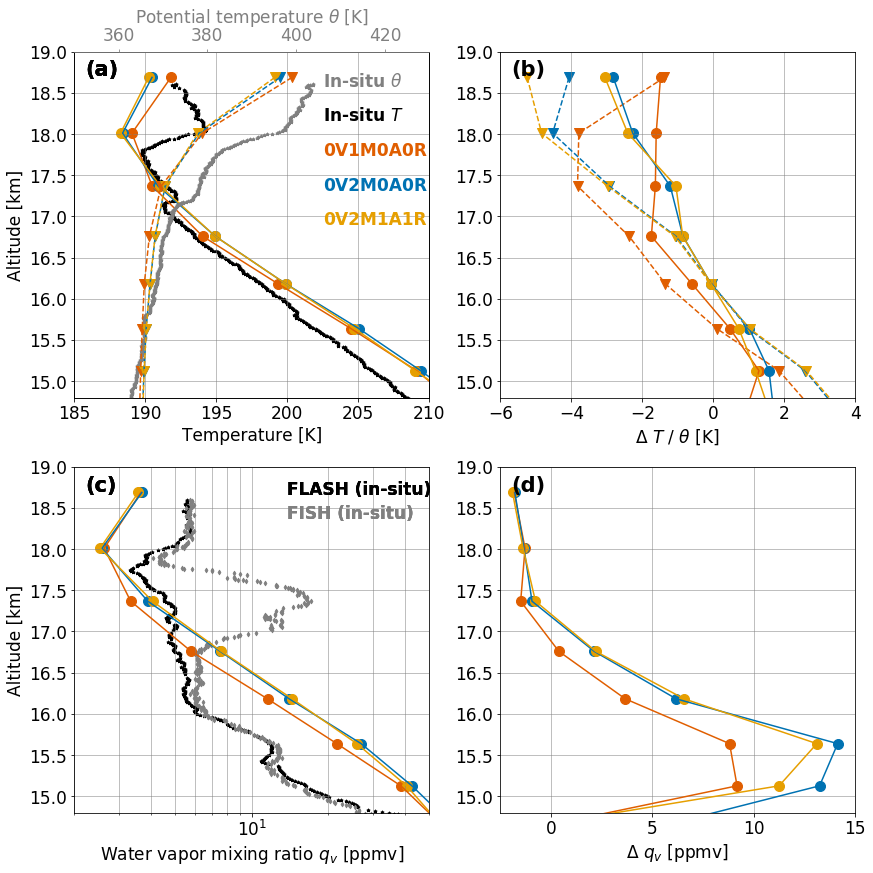

In [5]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y1 = 14.8
y2 = 19
icon_sz = 100
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.

# Whether we look at stats or stats_fixed is set above.
ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(temp, alt3/1000, color='k', s=10, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    # np.linspace(u,d,n)/1000 were the initial y-coordinates
    ax[0,0].scatter(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1), bins_sims/1000, s=icon_sz, color=farbe[s_name])
    ax[0,0].plot(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1), bins_sims/1000, linewidth=icon_lw, color=farbe[s_name])
    ax[0,0].set_ylim([y1, y2])
    ax[0,0].set_xlim([185, 210])
    ax[0,0].tick_params('both',labelsize=fs)
    ax[0,0].set_xlabel('Temperature [K]', fontsize=fs)
    ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
    ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)

ax0 = ax[0,0].twiny()
ax0.scatter(theta, alt3/1000, color='gray', s=10, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax0.scatter(np.nanmean(theta_ICON[s_indx,k,:,:20], axis=1), bins_sims/1000, marker='v', s=icon_sz, color=farbe[s_name])
    ax0.plot(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1), bins_sims/1000, ls='--', linewidth=icon_lw, color=farbe[s_name])
ax0.set_xlabel(r'Potential temperature $\theta$ [K]', fontsize=fs, color='gray')
ax0.spines['top'].set_color('gray')
ax0.tick_params(axis='x',colors='gray')
ax0.set_xlim([350, 430])
ax0.tick_params('both',labelsize=fs)
ax0.text(0.7, 0.9, r'In-situ $\theta$', fontsize=fs, weight='bold', color='gray', transform=ax0.transAxes)
ax0.text(0.7, 0.8, r'In-situ $T$', fontsize=fs, weight='bold', color='black', transform=ax0.transAxes)
ax0.text(0.7, 0.7, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax0.transAxes)
ax0.text(0.7, 0.6, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax0.transAxes)
ax0.text(0.7, 0.5, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax0.transAxes)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1) - temp_SC_stats[k], bins_sims/1000,
                   s=icon_sz, alpha=icon_alfa, color=farbe[s_name])
    ax[0,1].plot(np.nanmean(sim_stats[s_indx,0,k,:,:20],axis=1) - temp_SC_stats[k], bins_sims/1000,
                 linewidth=icon_lw, color=farbe[s_name])
    ax[0,1].scatter(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1) - theta_SC_stats[k], bins_sims/1000,
                    s=icon_sz, marker='v', alpha=icon_alfa, color=farbe[s_name])
    ax[0,1].plot(np.nanmean(theta_ICON[s_indx,k,:,:20],axis=1) - theta_SC_stats[k], bins_sims/1000,
                  linewidth=icon_lw, ls='--', color=farbe[s_name])
ax[0,1].set_ylim([y1, y2])
ax[0,1].set_xlim([-6, 4])
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].set_xlabel(r'$\Delta$ $T$ / $\theta$ [K]', fontsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[0,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qv_flash, alt1/1000, color='k', s=10, marker='*')
ax[1,0].scatter(qv_fish, alt1/1000, color='gray', s=10, marker='d')
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1), bins_sims/1000, s=icon_sz, color=farbe[s_name])
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1), bins_sims/1000, linewidth=icon_lw, color=farbe[s_name])
    ax[1,0].set_xlabel('Water vapor mixing ratio $q_v$ [ppmv]',fontsize=fs)
    ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
    ax[1,0].set_xlim(2,50)
    ax[1,0].set_ylim([y1, y2])
    ax[1,0].set_xscale('log')
    ax[1,0].text(0.6, 0.92, 'FLASH (in-situ)', fontsize=fs, weight='bold', transform=ax[1,0].transAxes)
    ax[1,0].text(0.6, 0.85, 'FISH (in-situ)', fontsize=fs, weight='bold', color='gray', transform=ax[1,0].transAxes)
    ax[1,0].tick_params('both', labelsize=fs)
    ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1) - qv_flash_SC_stats[k], bins_sims/1000,
                    s=icon_sz, alpha=icon_alfa, color=farbe[s_name])
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,2,k,:,:20],axis=1) - qv_flash_SC_stats[k], bins_sims/1000,
                  linewidth=icon_lw, color=farbe[s_name])
ax[1,1].set_ylim([y1, y2])
if tag == '_pinpoint':
    ax[1,1].set_xlim([-2.5, 2.5])
else:
    ax[1,1].set_xlim([-2.5, 15])
ax[1,1].tick_params('both', labelsize=fs)
ax[1,1].set_xlabel(r'$\Delta$ $q_v$ [ppmv]', fontsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/T-theta-qv-comp' + tag + '.pdf')

### (3b) Plot vertical profiles of RHi and qi for both in-situ measurements and ICON synthetic trajectories

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


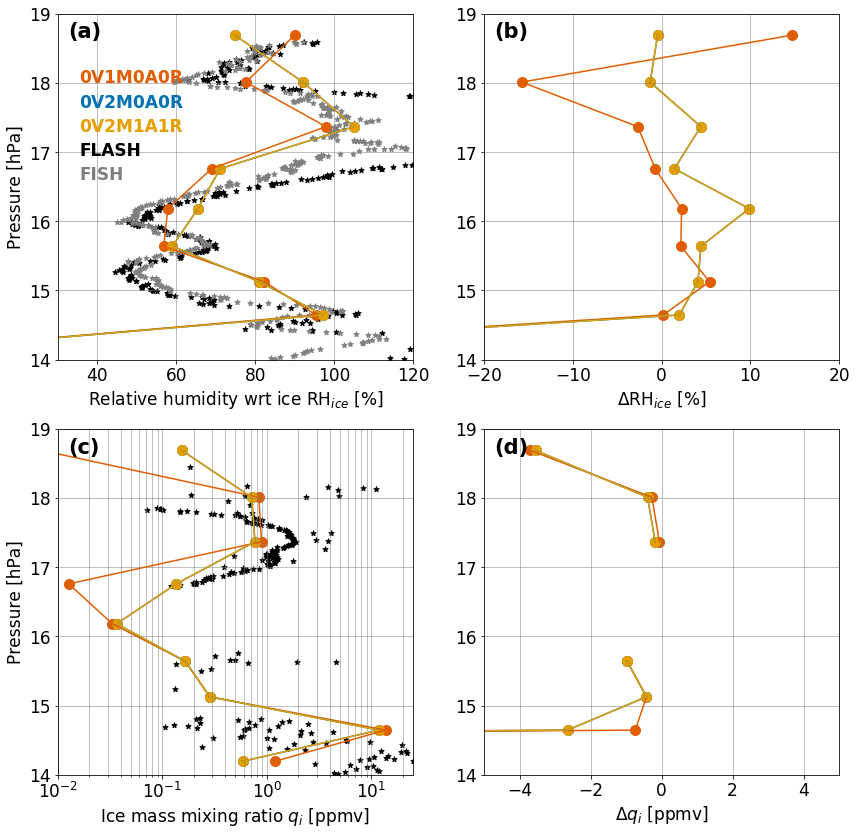

In [25]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y1 = 14
y2 = 19
icon_sz = 100
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.

ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(rhice_fish, alt4/1000, color='k', s=30, marker='*')
ax[0,0].scatter(rhice_flash, alt4/1000, color='gray', s=30, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax[0,0].scatter(np.nanmean(RH_ICON[s_indx,k], axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,0].plot(np.nanmean(RH_ICON[s_indx,k], axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[0,0].text(0.06, 0.8, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.73, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.66, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.59, 'FLASH', fontsize=fs, weight='bold', transform=ax[0,0].transAxes)
ax[0,0].text(0.06, 0.52, 'FISH', fontsize=fs, weight='bold', color='gray', transform=ax[0,0].transAxes)
ax[0,0].set_ylim([y1, y2])
ax[0,0].set_xlim([30, 120])
ax[0,0].set_xlabel(r'Relative humidity wrt ice RH$_{ice}$ [%]', fontsize=fs)
ax[0,0].set_ylabel('Pressure [hPa]', fontsize=fs)
ax[0,0].tick_params('both',labelsize=fs)
ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(RH_ICON[s_indx,k], axis=1) - RHi_SC_stats[k], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,1].plot(np.nanmean(RH_ICON[s_indx,k], axis=1) - RHi_SC_stats[k], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[0,1].set_ylim([y1, y2])
if tag == '_pinpoint':
    ax[0,1].set_xlim([-20, 20])
else:
    ax[0,1].set_xlim([-20, 80])
ax[0,1].set_xlabel(r'$\Delta$RH$_{ice}$ [%]', fontsize=fs)
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[0,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qi, alt2/1000, color='k', s=30, marker='*')

# We don't use k below because we are showing both the mean and median always.
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    #ax[1,0].scatter(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    #ax[1,0].plot(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xlim([0.01, 25])
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)
ax[1,0].set_ylabel('Pressure [hPa]', fontsize=fs)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    #ax[1,1].scatter(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    #ax[1,1].plot(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,1].set_ylim([y1, y2])
if tag == '_pinpoint':
    ax[1,1].set_xlim([-5, 5])
else:
    ax[1,1].set_xlim([-15, 5])
#ax[1,1].set_xscale('log')
ax[1,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[1,1].tick_params('both',labelsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/RHi-qi-comp' + tag + '.pdf')

### (3c) Plot vertical profiles of qi in temperature coordinates for both in-situ measurements and ICON synthetic trajectories

In [93]:
# All sets of trajectory statistics
stats_1M0A0R = np.nanmean( np.load( 'output/ICON_syntrajs_0V1M0A0R_stats.npy' ), axis=3)
stats_2M0A0R = np.nanmean( np.load( 'output/ICON_syntrajs_0V2M0A0R_stats.npy' ), axis=3)
stats_2M1A1R = np.nanmean( np.load( 'output/ICON_syntrajs_0V2M1A1R_stats.npy' ), axis=3)

stats_1M0A0R = np.reshape( stats_1M0A0R, (1, 4, 3, 13) )
stats_2M0A0R = np.reshape( stats_2M0A0R, (1, 4, 3, 13) )
stats_2M1A1R = np.reshape( stats_2M1A1R, (1, 4, 3, 13) )

tag_list = ['_2', '_collocate', '_pinpoint']
for t in tag_list:
    new = np.load('output/ICON_syntrajs_0V1M0A0R_stats' + t + '.npy')
    new = np.reshape( np.nanmean( new, axis=3 ), (1, 4, 3, 13) )
    stats_1M0A0R = np.concatenate( (stats_1M0A0R, new), axis=0 )
    
    new = np.load('output/ICON_syntrajs_0V2M0A0R_stats' + t + '.npy')
    new = np.reshape( np.nanmean( new, axis=3 ), (1, 4, 3, 13) )
    stats_2M0A0R = np.concatenate( (stats_2M0A0R, new), axis=0 )
    
    new = np.load('output/ICON_syntrajs_0V2M1A1R_stats' + t + '.npy')
    new = np.reshape( np.nanmean( new, axis=3 ), (1, 4, 3, 13) )
    stats_2M1A1R = np.concatenate( (stats_2M1A1R, new), axis=0 )

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


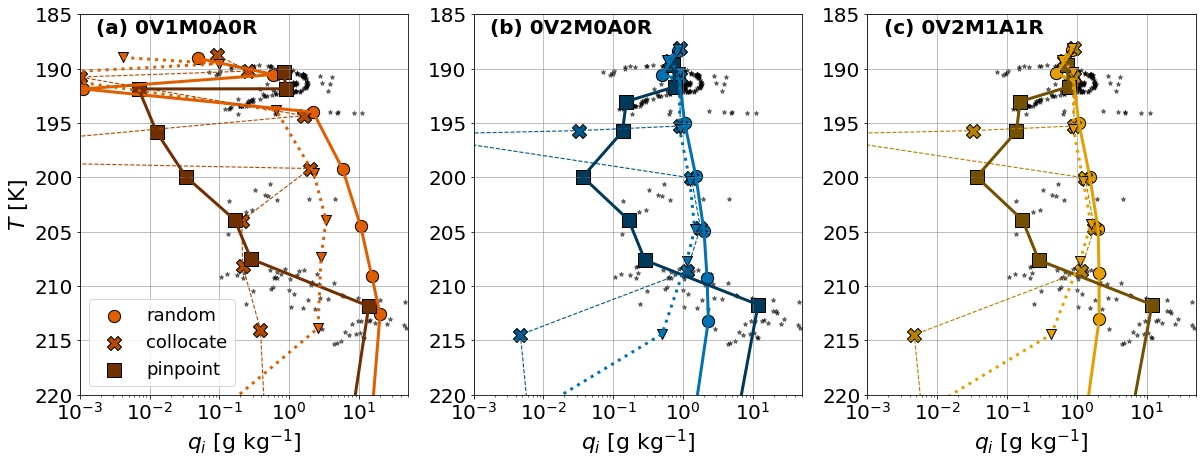

In [142]:
fs = 20
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
let = ['(a) 0V1M0A0R', '(b) 0V2M0A0R', '(c) 0V2M1A1R']

for s_indx, stats, s_name in zip( np.arange(3), [stats_1M0A0R, stats_2M0A0R, stats_2M1A1R], sim_list ):
    ax[s_indx].grid(b=True, which='major', axis='both', color='gray', linewidth=0.5)
    ax[s_indx].scatter(qi, temp, color='k', s=20, marker='*', alpha=0.5)
    
    plt_stuff = zip([0, 2, 3], [1, 0.8, 0.5], [1.5, 2, 2], [2, 0.75, 2], ['o','X','s'], ['-', '--', '-'], ['random', 'collocate', 'pinpoint'])
    for j, factor1, factor2, factor3, icon, stil, lbl in plt_stuff:
        f = tuple([factor1*x for x in farbe[s_name]])
        s = icon_sz*factor2
        qi_series = stats[j,3,0]
        t_series = stats[j,0,0]
        o = t_series.argsort()
        
        ax[s_indx].plot(qi_series[o], t_series[o], color=f, lw=icon_lw*factor3, ls=stil)
        ax[s_indx].scatter(qi_series[o], t_series[o], s=s, marker=icon, color=f, edgecolor='k', label=lbl)
    
    qi_series = stats[0,3,1]
    t_series = stats[0,0,1]
    o = t_series.argsort()
    ax[s_indx].plot(qi_series[o], t_series[o], color=farbe[s_name], ls=':', lw=icon_lw*2)
    ax[s_indx].scatter(qi_series[o], t_series[o], s=icon_sz, marker='v', edgecolor='k', color=farbe[s_name])
    ax[s_indx].invert_yaxis()
    ax[s_indx].set_xscale('log')
    ax[s_indx].set_ylim([220, 185])
    ax[s_indx].set_xlim([0.001, 50])
    ax[s_indx].tick_params('both', labelsize=fs)
    ax[s_indx].text(0.05, 0.95, let[s_indx], weight='bold', fontsize=fs, transform=ax[s_indx].transAxes)
    ax[s_indx].set_xlabel(r'$q_i$ [g kg$^{-1}$]', fontsize=fs+2)

leg = ax[0].legend(loc='lower left', fontsize=fs-2)
ax[0].set_ylabel(r'$T$ [K]', fontsize=fs+2)

#fig.savefig('output/qi-versus-T.pdf')

### (3d) Plot vertical profiles of qi in supersaturation coordinates for both in-situ measurements and ICON synthetic trajectories

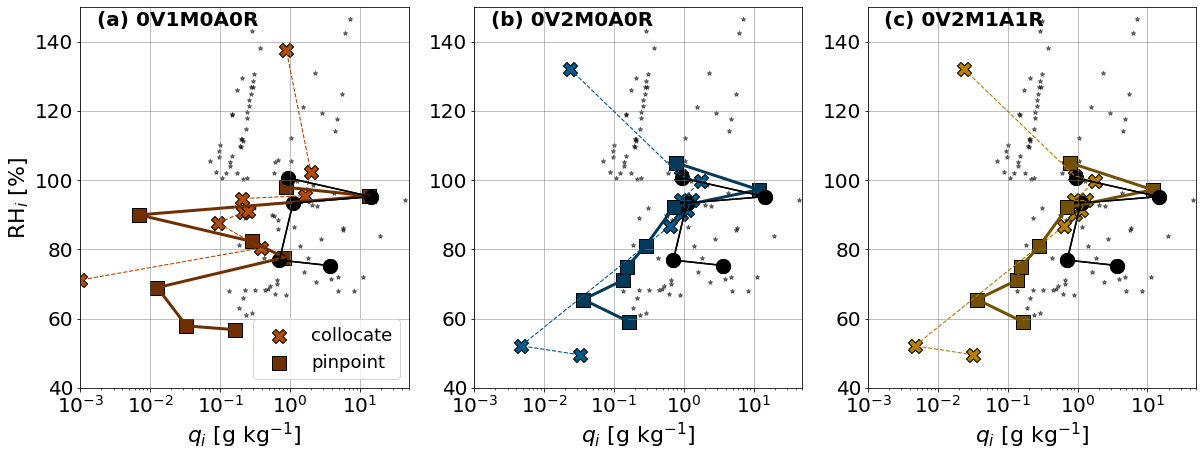

In [197]:
fs = 20
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
let = ['(a) 0V1M0A0R', '(b) 0V2M0A0R', '(c) 0V2M1A1R']

for s_indx, stats, s_name in zip( np.arange(3), [stats_1M0A0R, stats_2M0A0R, stats_2M1A1R], sim_list ):
    ax[s_indx].grid(b=True, which='major', axis='both', color='gray', linewidth=0.5)
    ax[s_indx].scatter(qi, rhice_fish, color='k', s=20, marker='*', alpha=0.5)
    
    plt_stuff = zip([2, 3], [0.8, 0.5], [2, 2], [0.75, 2], ['X','s'], ['--', '-'], ['collocate', 'pinpoint'])
    for j, factor1, factor2, factor3, icon, stil, lbl in plt_stuff:
        f = tuple([factor1*x for x in farbe[s_name]])
        s = icon_sz*factor2
        qi_series = stats[j,3,0]
        RHi_series = calc_RH( stats[j,0,0], stats[j,1,0], stats[j,2,0] )
        o = RHi_series.argsort()
        
        ax[s_indx].plot(qi_series[o[1:]], RHi_series[o[1:]], color=f, lw=icon_lw*factor3, ls=stil)
        ax[s_indx].scatter(qi_series[o[1:]], RHi_series[o[1:]], s=s, marker=icon, color=f, edgecolor='k', label=lbl)
        
        o = RHi_SC_stats[0].argsort()
        ax[s_indx].plot(qi_SC_stats[0,o[1:]], RHi_SC_stats[0,o[1:]], color='k', lw=1.5)
        ax[s_indx].scatter(qi_SC_stats[0,o[1:]], RHi_SC_stats[0,o[1:]], color='k', s=icon_sz*2)
    
    qi_series = stats[0,3,1]
    t_series = stats[0,0,1]
    o = t_series.argsort()
    ax[s_indx].set_xscale('log')
    ax[s_indx].set_ylim([40, 150])
    ax[s_indx].set_xlim([0.001, 50])
    ax[s_indx].tick_params('both', labelsize=fs)
    ax[s_indx].text(0.05, 0.95, let[s_indx], weight='bold', fontsize=fs, transform=ax[s_indx].transAxes)
    ax[s_indx].set_xlabel(r'$q_i$ [g kg$^{-1}$]', fontsize=fs+2)

leg = ax[0].legend(loc='lower right', fontsize=fs-2)
ax[0].set_ylabel(r'RH$_i$ [%]', fontsize=fs+2)

#fig.savefig('output/qi-versus-RHi.pdf')

In [ ]:
# (4) 

## How much variability in the synthetic trajectories?
### (1) Updraft velocities

In [25]:
basedir = '/work/bb1018/b380873/model_output/ICON/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_0V1M0A0R.nc')
w = syn_traj['omega'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

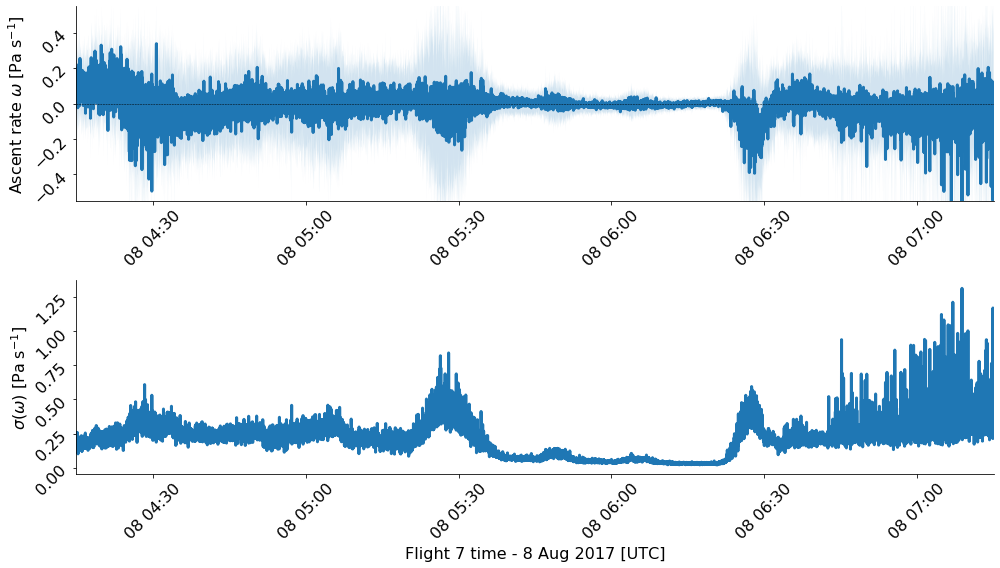

In [26]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
wm = w.mean(dim='ntraj')
wstd = w.std(dim='ntraj')
ax[0].plot(t, wm, linewidth=3)
ax[0].plot([t.min(), t.max()], [0, 0], color='k', linestyle='--', linewidth=0.5)
ax[0].plot()
ax[0].fill_between(t, wm - wstd, wm + wstd, alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylim([-0.55, 0.55])
ax[0].set_ylabel(r'Ascent rate $\omega$ [Pa s$^{-1}$]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, wstd, linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(\omega)$ [Pa s$^{-1}$]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()
#fig.savefig('output/syntraj_wcheck_full.pdf',bbox_inches='tight')
plt.show()

### (2) Temperatures

In [27]:
T = syn_traj['temp'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
T_Stratoclim = daten['BEST:TEMP'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

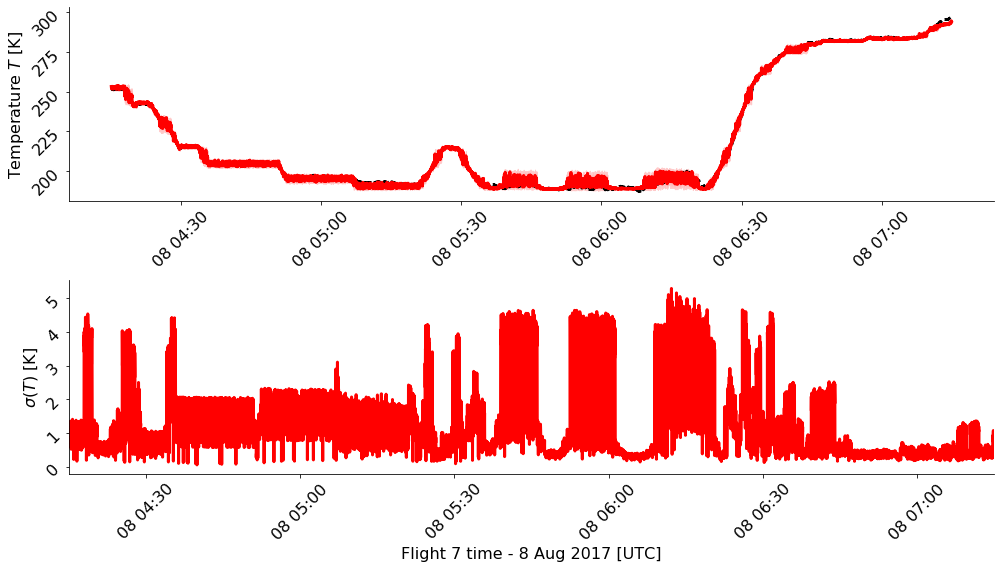

In [28]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
Tm = T.mean(dim='ntraj')
Tstd = T.std(dim='ntraj')
ax[0].plot(t_Stratoclim, T_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, Tm, color='red', linewidth=3)
ax[0].fill_between(t, Tm - Tstd, Tm + Tstd, color='red', alpha=0.2)
#ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Temperature $T$ [K]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, Tstd, color='red', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(T)$ [K]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

#fig.savefig('output/syntraj_Tcheck_full.pdf',bbox_inches='tight')
plt.show()

### (3) Ice mass mixing ratios

In [29]:
qi = syn_traj['qi'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Multiply qv_s by 10^6 to translate kg kg-1 to ppmv.
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qim_ppmv = qi.mean(dim='ntraj') * conv * 10**6
qistd_ppmv = qi.std(dim='ntraj') * conv * 10**6

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
qi_Stratoclim = daten['BEST:IWC'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

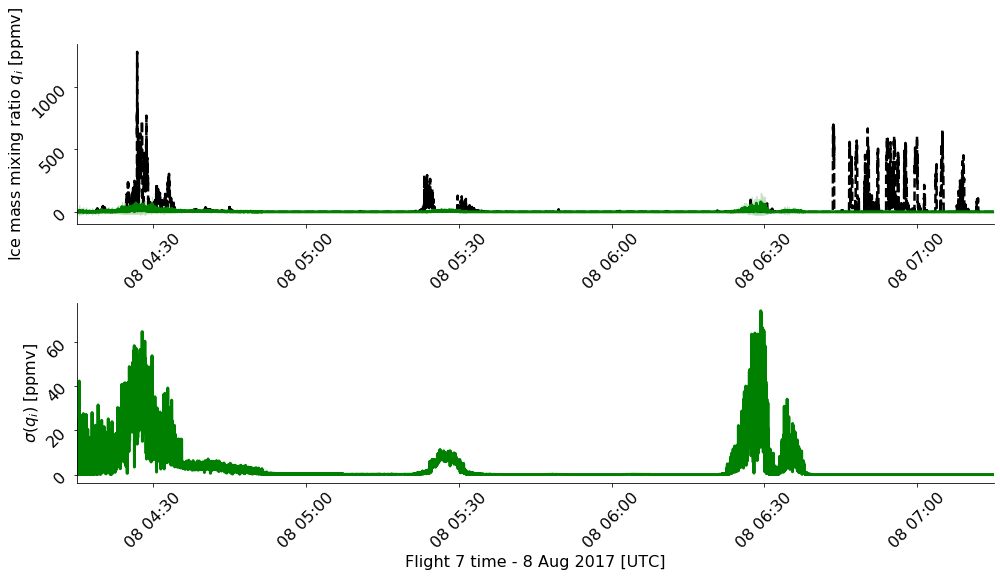

In [30]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax[0].plot(t_Stratoclim, qi_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, qim_ppmv, color='green', linewidth=3)
ax[0].fill_between(t, qim_ppmv - qistd_ppmv, qim_ppmv + qistd_ppmv, color='green', alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, qistd_ppmv, color='green', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(q_i)$ [ppmv]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

#fig.savefig('output/syntraj_qicheck_full.pdf',bbox_inches='tight')
plt.show()

### (4) Vapor mass mixing ratios

In [33]:
qv = syn_traj['qv'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Multiply qv_s by 10^6 to translate kg kg-1 to ppmv.
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qvm_ppmv = qv.mean(dim='ntraj') #* conv * 10**6
qvstd_ppmv = qv.std(dim='ntraj') #* conv * 10**6

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
qv_Stratoclim = daten['BEST:H2O_enh'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

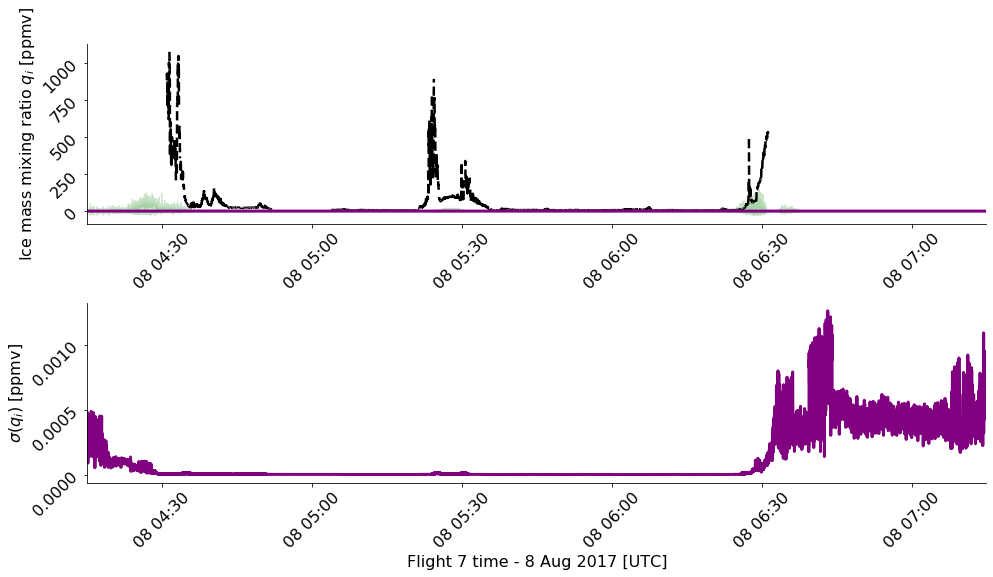

In [34]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax[0].plot(t_Stratoclim, qv_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, qvm_ppmv, color='purple', linewidth=3)
ax[0].fill_between(t, qim_ppmv - qistd_ppmv, qim_ppmv + qistd_ppmv, color='green', alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, qvstd_ppmv, color='purple', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(q_i)$ [ppmv]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

#fig.savefig('output/syntraj_qicheck_full.pdf',bbox_inches='tight')
plt.show()

## Unused chunks of code